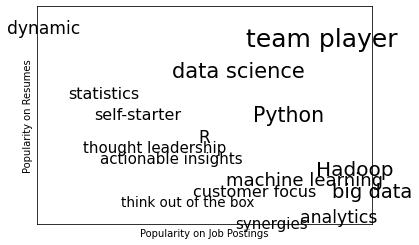

In [16]:
# NATURAL LANGUAGE PROCESSING
# it refers to computational techniques involving language

import data_lib
from data_lib import Vector, Tensor
from typing import List, Dict, Tuple, Iterable
from collections import defaultdict, Counter
import math
import random
import tqdm
import re

# word cloud
data = [ ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50),
         ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60),
         ("data science", 60, 70), ("analytics", 90, 3),
         ("team player", 85, 85), ("dynamic", 2, 90), ("synergies", 70, 0),
         ("actionable insights", 40, 30), ("think out of the box", 45, 10),
         ("self-starter", 30, 50), ("customer focus", 65, 15),
         ("thought leadership", 35, 35)]

from matplotlib import pyplot as plt

def text_size(total: int) -> float:
    """equals 8 if total is 0, 28 if total is 200"""
    return 8 + total / 200 * 20

for word, job_popularity, resume_popularity in data:
    plt.text(job_popularity, resume_popularity, word,
             ha='center', va='center',
             size=text_size(job_popularity + resume_popularity))
plt.xlabel("Popularity on Job Postings")
plt.ylabel("Popularity on Resumes")
plt.axis([0, 100, 0, 100])
plt.xticks([])
plt.yticks([])
plt.show()

In [17]:
import re
from bs4 import BeautifulSoup
import requests

url = "https://www.oreilly.com/ideas/what-is-data-science"
html = requests.get(url, verify = False).text
soup = BeautifulSoup(html, 'html5lib')
content = soup.find_all('p')   # find all paragraphs
regex = r"[\w']+|[\.]"                       # matches a word or a period
document = []

def fix_unicode(text: str) -> str:
    return text.replace(u"\u2019", "'")

for paragraph in content:
    words = re.findall(regex, fix_unicode(paragraph.text))
    document.extend(words)

c:\Users\baldif\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.oreilly.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\baldif\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.oreilly.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(
c:\Users\baldif\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.oreilly.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


In [18]:
# let's generate sentences using bigrams
transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
    transitions[prev].append(current)

def generate_using_bigrams() -> str:
    current = "."   # this means the next word will start a sentence
    result = []
    while True:
        next_word_candidates = transitions[current]    # bigrams (current, _)
        current = random.choice(next_word_candidates)  # choose one at random
        result.append(current)                         # append it to results
        if current == ".": return " ".join(result)     # if "." we're done

# another approach is to use grammars to generate sentences
# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]
grammar = {
    "_S"  : ["_NP _VP"],
    "_NP" : ["_N",
             "_A _NP _P _A _N"],
    "_VP" : ["_V",
             "_V _NP"],
    "_N"  : ["data science", "Python", "regression"],
    "_A"  : ["big", "linear", "logistic"],
    "_P"  : ["about", "near"],
    "_V"  : ["learns", "trains", "tests", "is"]
}

def is_terminal(token: str) -> bool:
    return token[0] != "_"

def expand(grammar: Grammar, tokens: List[str]) -> List[str]:
    for i, token in enumerate(tokens):
        # If this is a terminal token, skip it.
        if is_terminal(token): continue
        # Otherwise, it's a nonterminal token,
        # so we need to choose a replacement at random.
        replacement = random.choice(grammar[token])
        if is_terminal(replacement):
            tokens[i] = replacement
        else:
            # Replacement could be, e.g., "_NP _VP", so we need to
            # split it on spaces and splice it in.
            tokens = tokens[:i] + replacement.split() + tokens[(i+1):]
        # Now call expand on the new list of tokens.
        return expand(grammar, tokens)

    # If we get here, we had all terminals and are done.
    return tokens

def generate_sentence(grammar: Grammar) -> List[str]:
    return expand(grammar, ["_S"])

# generating from distributions, Gibbs Sampling

def roll_a_die() -> int:
    return random.choice([1, 2, 3, 4, 5, 6])

def direct_sample() -> Tuple[int, int]:
    d1 = roll_a_die()
    d2 = roll_a_die()
    return d1, d1 + d2

def random_y_given_x(x: int) -> int:
    """equally likely to be x + 1, x + 2, ... , x + 6"""
    return x + roll_a_die()

# the other direction is harder to guess
def random_x_given_y(y: int) -> int:
    if y <= 7:
        # if the total is 7 or less, the first die is equally likely to be
        # 1, 2, ..., (total - 1)
        return random.randrange(1, y)
    else:
        # if the total is 7 or more, the first die is equally likely to be
        # (total - 6), (total - 5), ..., 6
        return random.randrange(y - 6, 7)

# we start with any valid values for x and y, then repeatedly alternate replacing x or y with a random value.
def gibbs_sample(num_iters: int = 100) -> Tuple[int, int]:
    x, y = 1, 2 # doesn't really matter
    for _ in range(num_iters):
        x = random_x_given_y(y)
        y = random_y_given_x(x)
    return x, y

def compare_distributions(num_samples: int = 1000) -> Dict[int, List[int]]:
    counts = defaultdict(lambda: [0, 0])
    for _ in range(num_samples):
        counts[gibbs_sample()][0] += 1
        counts[direct_sample()][1] += 1
    return counts

In [19]:
# topic modeling
def sample_from(weights: List[float]) -> int:
    """returns i with probability weights[i] / sum(weights)"""
    total = sum(weights)
    rnd = total * random.random()      # uniform between 0 and total
    for i, w in enumerate(weights):
        rnd -= w                       # return the smallest i such that
        if rnd <= 0: return i          # weights[0] + ... + weights[i] >= rnd

# Draw 1000 times and count
draws = Counter(sample_from([0.1, 0.1, 0.8]) for _ in range(1000))
assert 10 < draws[0] < 190   # should be ~10%, this is a really loose test
assert 10 < draws[1] < 190   # should be ~10%, this is a really loose test
assert 650 < draws[2] < 950  # should be ~80%, this is a really loose test
assert draws[0] + draws[1] + draws[2] == 1000

documents = [ # example topics in documents
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

K = 4
# How many times each topic is assigned to each document:
# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# How many times each word is assigned to each topic:
# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# The total number of words assigned to each topic:
# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# The total number of words contained in each document:
# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

# The number of distinct words:
distinct_words = set(word for document in documents for word in document)
W = len(distinct_words)

# The number of documents:
D = len(documents)

def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
    """
    The fraction of words in document 'd'
    that are assigned to 'topic' (plus some smoothing)
    """
    return ((document_topic_counts[d][topic] + alpha) /
            (document_lengths[d] + K * alpha))

def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
    """
    The fraction of words assigned to 'topic'
    that equal 'word' (plus some smoothing)
    """
    return ((topic_word_counts[topic][word] + beta) /
            (topic_counts[topic] + W * beta))

def topic_weight(d: int, word: str, k: int) -> float:
    """
    Given a document and a word in that document,
    return the weight for the kth topic
    """
    return p_word_given_topic(word, k) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str) -> int:
    return sample_from([topic_weight(d, word, k)
                        for k in range(K)])

# ready to calculate 
random.seed(0)
document_topics = [[random.randrange(K) for word in document]
                   for document in documents]

for d in range(D):
    for word, topic in zip(documents[d], document_topics[d]):
        document_topic_counts[d][topic] += 1
        topic_word_counts[topic][word] += 1
        topic_counts[topic] += 1

for iter in tqdm.trange(1000):
    for d in range(D):
        for i, (word, topic) in enumerate(zip(documents[d],
                                              document_topics[d])):
            # remove this word / topic from the counts
            # so that it doesn't influence the weights
            document_topic_counts[d][topic] -= 1
            topic_word_counts[topic][word] -= 1
            topic_counts[topic] -= 1
            document_lengths[d] -= 1
            
            # choose a new topic based on the weights
            new_topic = choose_new_topic(d, word)
            document_topics[d][i] = new_topic

            # and now add it back to the counts
            document_topic_counts[d][new_topic] += 1
            topic_word_counts[new_topic][word] += 1
            topic_counts[new_topic] += 1
            document_lengths[d] += 1

# use names instead of numbers   
for k, word_counts in enumerate(topic_word_counts):
    for word, count in word_counts.most_common():
        if count > 0:
            0 #print(k, word, count)

# assign names to the topics
topic_names = ["Big Data and programming languages",
               "Python and statistics",
               "databases",
               "machine learning"]

for document, topic_counts in zip(documents, document_topic_counts):
    print(document)
    for topic, count in topic_counts.most_common():
        if count > 0:
            print(topic_names[topic], count)
    print()

100%|██████████| 1000/1000 [00:00<00:00, 2159.86it/s]

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data and programming languages 7

['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
Python and statistics 5

['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
Python and statistics 2
databases 2
machine learning 2

['R', 'Python', 'statistics', 'regression', 'probability']
machine learning 3
databases 2

['machine learning', 'regression', 'decision trees', 'libsvm']
databases 2
Python and statistics 2

['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
databases 3
Big Data and programming languages 3

['statistics', 'probability', 'mathematics', 'theory']
machine learning 3
databases 1

['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
databases 2
Python and statistics 2

['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
Python and statistics 3
Big Data and programming languages 1

['Hadoop', 'Java', 'MapReduce', 'Big Data']
Big D

In [20]:
# word vectors
# Create a dataset where the goal is to predict a word given nearby words
def cosine_similarity(v1: Vector, v2: Vector) -> float:
    return data_lib.dot(v1, v2) / math.sqrt(data_lib.dot(v1, v1) * data_lib.dot(v2, v2))

assert cosine_similarity([1., 1, 1], [2., 2, 2]) == 1, "same direction"
assert cosine_similarity([-1., -1], [2., 2]) == -1,    "opposite direction"
assert cosine_similarity([1., 0], [0., 1]) == 0,       "orthogonal"

colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

def make_sentence() -> str:
    return " ".join([
        "The",
        random.choice(colors),
        random.choice(nouns),
        random.choice(verbs),
        random.choice(adverbs),
        random.choice(adjectives),
        "."
    ])

NUM_SENTENCES = 50
random.seed(0)
sentences = [make_sentence() for _ in range(NUM_SENTENCES)]

# we need a vocabulary to keep track of the mapping
class Vocabulary:
    def __init__(self, words: List[str] = None) -> None:
        self.w2i: Dict[str, int] = {}  # mapping word -> word_id
        self.i2w: Dict[int, str] = {}  # mapping word_id -> word
        for word in (words or []):     # If words were provided,
            self.add(word)             # add them.

    @property
    def size(self) -> int:
        """how many words are in the vocabulary"""
        return len(self.w2i)

    def add(self, word: str) -> None:
        if word not in self.w2i:        # If the word is new to us:
            word_id = len(self.w2i)     # Find the next id.
            self.w2i[word] = word_id    # Add to the word -> word_id map.
            self.i2w[word_id] = word    # Add to the word_id -> word map.

    def get_id(self, word: str) -> int:
        """return the id of the word (or None)"""
        return self.w2i.get(word)

    def get_word(self, word_id: int) -> str:
        """return the word with the given id (or None)"""
        return self.i2w.get(word_id)

    def one_hot_encode(self, word: str) -> data_lib.Tensor:
        word_id = self.get_id(word)
        assert word_id is not None, f"unknown word {word}"

        return [1.0 if i == word_id else 0.0 for i in range(self.size)]

vocab = Vocabulary(["a", "b", "c"])
assert vocab.size == 3,              "there are 3 words in the vocab"
assert vocab.get_id("b") == 1,       "b should have word_id 1"
assert vocab.one_hot_encode("b") == [0, 1, 0]
assert vocab.get_id("z") is None,    "z is not in the vocab"
assert vocab.get_word(2) == "c",     "word_id 2 should be c"
vocab.add("z")
assert vocab.size == 4,              "now there are 4 words in the vocab"
assert vocab.get_id("z") == 3,       "now z should have id 3"
assert vocab.one_hot_encode("z") == [0, 0, 0, 1]

# helper functions to save it in a .json file
import json

def save_vocab(vocab: Vocabulary, filename: str) -> None:
    with open(filename, 'w') as f:
        json.dump(vocab.w2i, f)       # Only need to save w2i

def load_vocab(filename: str) -> Vocabulary:
    vocab = Vocabulary()
    with open(filename) as f:
        # Load w2i and generate i2w from it
        vocab.w2i = json.load(f)
        vocab.i2w = {id: word for word, id in vocab.w2i.items()}
    return vocab

In [21]:
# we want to train the model with a neural network
# let's create an Embedding layer that embed generic stuff, and later define a subclass for word vectors
class Embedding(data_lib.Layer):
    def __init__(self, num_embeddings: int, embedding_dim: int) -> None:
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        # One vector of size embedding_dim for each desired embedding
        self.embeddings = data_lib.random_tensor(num_embeddings, embedding_dim)
        self.grad = data_lib.zeros_like(self.embeddings)
        # Save last input id
        self.last_input_id = None

    def forward(self, input_id: int) -> Tensor:
        """Just select the embedding vector corresponding to the input id"""
        self.input_id = input_id    # remember for use in backpropagation

        return self.embeddings[input_id]

    def backward(self, gradient: Tensor) -> None:
        # Zero out the gradient corresponding to the last input.
        # This is way cheaper than creating a new all-zero tensor each time.
        if self.last_input_id is not None:
            zero_row = [0 for _ in range(self.embedding_dim)]
            self.grad[self.last_input_id] = zero_row
        self.last_input_id = self.input_id
        self.grad[self.input_id] = gradient
    
    def params(self) -> Iterable[Tensor]:
        return [self.embeddings]

    def grads(self) -> Iterable[Tensor]:
        return [self.grad]

class TextEmbedding(Embedding):
    def __init__(self, vocab: Vocabulary, embedding_dim: int) -> None:
        # Call the superclass constructor
        super().__init__(vocab.size, embedding_dim)
        # And hang onto the vocab
        self.vocab = vocab

    def __getitem__(self, word: str) -> Tensor:
        word_id = self.vocab.get_id(word)
        if word_id is not None:
            return self.embeddings[word_id]
        else:
            return None
    
    def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
        """Returns the n closest words based on cosine similarity"""
        vector = self[word]
        # Compute pairs (similarity, other_word), and sort most similar first
        scores = [(cosine_similarity(vector, self.embeddings[i]), other_word)
                  for other_word, i in self.vocab.w2i.items()]
        scores.sort(reverse=True)

        return scores[:n]

In [22]:
# let’s start by lowercasing the sentences and splitting them into words. This is not a great regex, but it works on our data.
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                       for sentence in sentences]

# create a vocabulary (that is, a mapping word -> word_id) based on our text.
vocab = Vocabulary(word
                   for sentence_words in tokenized_sentences
                   for word in sentence_words)
inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tokenized_sentences:
    for i, word in enumerate(sentence):          # For each word
        for j in [i - 2, i - 1, i + 1, i + 2]:   # take the nearby locations
            if 0 <= j < len(sentence):           # that aren't out of bounds
                nearby_word = sentence[j]        # and get those words.
                # Add an input that's the original word_id
                inputs.append(vocab.get_id(word))
                # Add a target that's the one-hot-encoded nearby word
                targets.append(vocab.one_hot_encode(nearby_word))

random.seed(0)
EMBEDDING_DIM = 5  # seems like a good size
# Define the embedding layer separately, so we can reference it.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM)
model = data_lib.Sequential([
    # Given a word (as a vector of word_ids), look up its embedding.
    embedding,
    # And use a linear layer to compute scores for "nearby words."
    data_lib.Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size)
])

loss = data_lib.SoftmaxCrossEntropy()
optimizer = data_lib.GradientDescent(learning_rate=0.01)

for epoch in range(100):
    epoch_loss = 0.0
    for input, target in zip(inputs, targets):
        predicted = model.forward(input)
        epoch_loss += loss.loss(predicted, target)
        gradient = loss.gradient(predicted, target)
        model.backward(gradient)
        optimizer.step(model)
    print(epoch, epoch_loss)            # Print the loss
    print(embedding.closest("black"))   # and also a few nearest words
    print(embedding.closest("slow"))    # so we can see what's being
    print(embedding.closest("car"))     # learned.

pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
         for w1 in vocab.w2i
         for w2 in vocab.w2i
         if w1 < w2]
pairs.sort(reverse=True)
print(pairs[:5])

0 2970.156429387063
[(1.0, 'black'), (0.7927247753692507, 'blue'), (0.5911733314896048, 'cat'), (0.5716654981660781, 'the'), (0.3026892975059721, 'car')]
[(1.0, 'slow'), (0.8936272640937163, 'green'), (0.5272141409772461, '.'), (0.356013304388346, 'yellow'), (0.29982973123116025, 'blue')]
[(1.0, 'car'), (0.7030889033452818, 'cat'), (0.519105254858335, 'fast'), (0.4236692673437953, 'very'), (0.3848186865089063, 'quite')]
1 2865.855510833289
[(1.0, 'black'), (0.8076054877794636, 'blue'), (0.611245900026446, 'cat'), (0.5676562111596322, 'the'), (0.3273307461476133, 'car')]
[(1.0, 'slow'), (0.8795208130766505, 'green'), (0.5675261127213351, '.'), (0.3624106663078739, 'yellow'), (0.3593451263736934, 'boat')]
[(1.0, 'car'), (0.7121322616680856, 'cat'), (0.49717481866583696, 'fast'), (0.4099921723101964, 'very'), (0.3655326707405853, 'quite')]
2 2815.0355266564657
[(1.0, 'black'), (0.8240340241906855, 'blue'), (0.6310891601317346, 'cat'), (0.5448895203899405, 'the'), (0.3541498544488745, 'car

dv: 43.206: 100%|██████████| 100/100 [00:00<00:00, 283.29it/s]


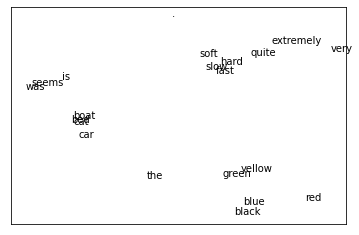

In [23]:
# Extract the first two principal components and transform the word vectors
components = data_lib.pca(embedding.embeddings, 2)
transformed = data_lib.transform(embedding.embeddings, components)

# Scatter the points (and make them white so they're "invisible")
fig, ax = plt.subplots()
ax.scatter(*zip(*transformed), marker='.', color='w')
# Add annotations for each word at its transformed location
for word, idx in vocab.w2i.items():
    ax.annotate(word, transformed[idx])
# And hide the axes
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.show()

In [24]:
# recurrent neural networks
# it has an hidden layer that can "remember" the inputs they have seen.
class SimpleRnn(data_lib.Layer):
    """Just about the simplest possible recurrent layer."""
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.w = data_lib.random_tensor(hidden_dim, input_dim, init='xavier')
        self.u = data_lib.random_tensor(hidden_dim, hidden_dim, init='xavier')
        self.b = data_lib.random_tensor(hidden_dim)
        self.reset_hidden_state()

    def reset_hidden_state(self) -> None:
        self.hidden = [0 for _ in range(self.hidden_dim)]

    def forward(self, input: Tensor) -> Tensor:
        self.input = input              # Save both input and previous
        self.prev_hidden = self.hidden  # hidden state to use in backprop.
        a = [(data_lib.dot(self.w[h], input) +           # weights @ input
              data_lib.dot(self.u[h], self.hidden) +     # weights @ hidden
              self.b[h])                        # bias
             for h in range(self.hidden_dim)]
        self.hidden = data_lib.tensor_apply(data_lib.tanh, a)  # Apply tanh activation
        return self.hidden                   # and return the result.

    def backward(self, gradient: Tensor):
        # Backpropagate through the tanh
        a_grad = [gradient[h] * (1 - self.hidden[h] ** 2)
                  for h in range(self.hidden_dim)]
        # b has the same gradient as a
        self.b_grad = a_grad
        # Each w[h][i] is multiplied by input[i] and added to a[h],
        # so each w_grad[h][i] = a_grad[h] * input[i]
        self.w_grad = [[a_grad[h] * self.input[i]
                        for i in range(self.input_dim)]
                       for h in range(self.hidden_dim)]
        # Each u[h][h2] is multiplied by hidden[h2] and added to a[h],
        # so each u_grad[h][h2] = a_grad[h] * prev_hidden[h2]
        self.u_grad = [[a_grad[h] * self.prev_hidden[h2]
                        for h2 in range(self.hidden_dim)]
                       for h in range(self.hidden_dim)]
        # Each input[i] is multiplied by every w[h][i] and added to a[h],
        # so each input_grad[i] = sum(a_grad[h] * w[h][i] for h in ...)
        return [sum(a_grad[h] * self.w[h][i] for h in range(self.hidden_dim))
                for i in range(self.input_dim)]

    def params(self) -> Iterable[Tensor]:
        return [self.w, self.u, self.b]

    def grads(self) -> Iterable[Tensor]:
        return [self.w_grad, self.u_grad, self.b_grad]

In [28]:
# let's try to find a different name for a social network
url = "https://www.ycombinator.com/topcompanies/"
soup = BeautifulSoup(requests.get(url, verify = False).text, 'html5lib')

# We get the companies twice, so use a set comprehension to deduplicate.
companies = list({b.text for b in soup("a")
                  if "company-name" in b.get("class", ())})
print(len(companies))
companies = companies[:101]
vocab = Vocabulary([c for company in companies for c in company])

START = "^"
STOP = "$"
# We need to add them to the vocabulary too.
vocab.add(START)
vocab.add(STOP)

HIDDEN_DIM = 32  # You should experiment with different sizes!
rnn1 =  SimpleRnn(input_dim=vocab.size, hidden_dim=HIDDEN_DIM)
rnn2 =  SimpleRnn(input_dim=HIDDEN_DIM, hidden_dim=HIDDEN_DIM)
linear = data_lib.Linear(input_dim=HIDDEN_DIM, output_dim=vocab.size)
model = data_lib.Sequential([
    rnn1,
    rnn2,
    linear
])

def generate(seed: str = START, max_len: int = 50) -> str:
    rnn1.reset_hidden_state()  # Reset both hidden states
    rnn2.reset_hidden_state()
    output = [seed]            # Start the output with the specified seed
    # Keep going until we produce the STOP character or reach the max length
    while output[-1] != STOP and len(output) < max_len:
        # Use the last character as the input
        input = vocab.one_hot_encode(output[-1])
        # Generate scores using the model
        predicted = model.forward(input)
        # Convert them to probabilities and draw a random char_id
        probabilities = data_lib.softmax(predicted)
        next_char_id = sample_from(probabilities)
        # Add the corresponding char to our output
        output.append(vocab.get_word(next_char_id))

    # Get rid of START and END characters and return the word
    return ''.join(output[1:-1])

loss = data_lib.SoftmaxCrossEntropy()
optimizer = data_lib.Momentum(learning_rate=0.01, momentum=0.9)

for epoch in range(300):
    random.shuffle(companies)  # Train in a different order each epoch.
    epoch_loss = 0             # Track the loss.
    for company in companies:
        rnn1.reset_hidden_state()  # Reset both hidden states.
        rnn2.reset_hidden_state()
        company = START + company + STOP   # Add START and STOP characters.
        # The rest is just our usual training loop, except that the inputs
        # and target are the one-hot-encoded previous and next characters.
        for prev, next in zip(company, company[1:]):
            input = vocab.one_hot_encode(prev)
            target = vocab.one_hot_encode(next)
            predicted = model.forward(input)
            epoch_loss += loss.loss(predicted, target)
            gradient = loss.gradient(predicted, target)
            model.backward(gradient)
            optimizer.step(model)

    # Each epoch, print the loss and also generate a name.
    print(epoch, epoch_loss, generate())
    # Turn down the learning rate for the last 100 epochs.
    # There's no principled reason for this, but it seems to work.
    if epoch == 200:
        optimizer.lr *= 0.1

c:\Users\baldif\Anaconda3\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ycombinator.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


315
0 3575.1161574405223 MSv
1 3421.557901186825  psooucreWo
2 3350.795741075419 k1vtk i
3 3289.936364771848 eexnsuibnlutaelat
4 3237.346270548693 Seesp4rfa
5 3206.415526230171 vraitrlHf.ot
6 3168.785728850664 JWHrgtfio wh
7 3132.390193542992 Caheol
8 3103.6507332233687 WlaBoces
9 3063.199005144575 EaBrbl3Rav
10 3033.4682965326997 Cobpmsla3uenya.n
11 3016.7261220839014 Weeeaiab
12 3000.1538817231367 Cddf Trat
13 2991.115422383059 RhouochonG
14 2982.172790892578 Kptttttpeit
15 2973.898985390749 Sregoai
16 2962.927564351685 Mdt FaoTcEale
17 2953.61417423672 Sutaayoy
18 2947.5456928730378 Cermtmireot
19 2943.032611219401 Lefe Ieaiteii Timsof ti qdnr
20 2937.6498255677316 Bmdcng Pel
21 2930.4235707663015 Teek
22 2917.166836515121 Xebe Boas Bngnai
23 2904.627546975819 Bomilo
24 2900.209244277264 Sibxeb Kesee
25 2899.224816318878 CuaPm
26 2885.5471647823206 Gerimoobret
27 2881.921592626609 Fepwpifil
28 2859.420361707937 Mhpl
29 2864.046139089616 Sdpc
30 2846.40387044739 Aiwb Bele
31 2830.462